In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
import wrangle

In [3]:
mall_df, train, validate, test = wrangle.wrangle_mall_df()


NumExpr defaulting to 8 threads.


In [4]:
mall_df.head()

,customer_id,age,annual_income,spending_score,is_male
0,1,19,15,39,1
1,2,21,15,81,1
2,3,20,16,6,0
3,4,23,16,77,0
4,5,31,17,40,0


In [7]:
mall_df.shape

(198, 5)

In [5]:
train.shape, validate.shape, test.shape

((118, 5), (40, 5), (40, 5))

In [6]:
train.shape

(118, 5)

In [9]:
wrangle.summarize_data(mall_df, 10)

1) DATAFRAME SHAPE
---------------
Rows: 198
Columns: 5


2) DATAFRAME INFO
--------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 0 to 197
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer_id     198 non-null    int64
 1   age             198 non-null    int64
 2   annual_income   198 non-null    int64
 3   spending_score  198 non-null    int64
 4   is_male         198 non-null    uint8
dtypes: int64(4), uint8(1)
memory usage: 7.9 KB
None


3) UNIQUE VALUES BY COLUMN
-----------------------
CUSTOMER_ID
-----------
Number of Unique Values for customer_id: 198
This column has > 10 values


AGE
---
Number of Unique Values for age: 51
This column has > 10 values


ANNUAL_INCOME
-------------
Number of Unique Values for annual_income: 63
This column has > 10 values


SPENDING_SCORE
--------------
Number of Unique Values for spending_score: 83
This column has > 10 values


IS_MALE
------

,customer_id,age,annual_income,spending_score,is_male
0,1,19,15,39,1
1,2,21,15,81,1
2,3,20,16,6,0
3,4,23,16,77,0
4,5,31,17,40,0


>### Target Variable: `spending_score`

## 1. What is the distribution of each of the variables?

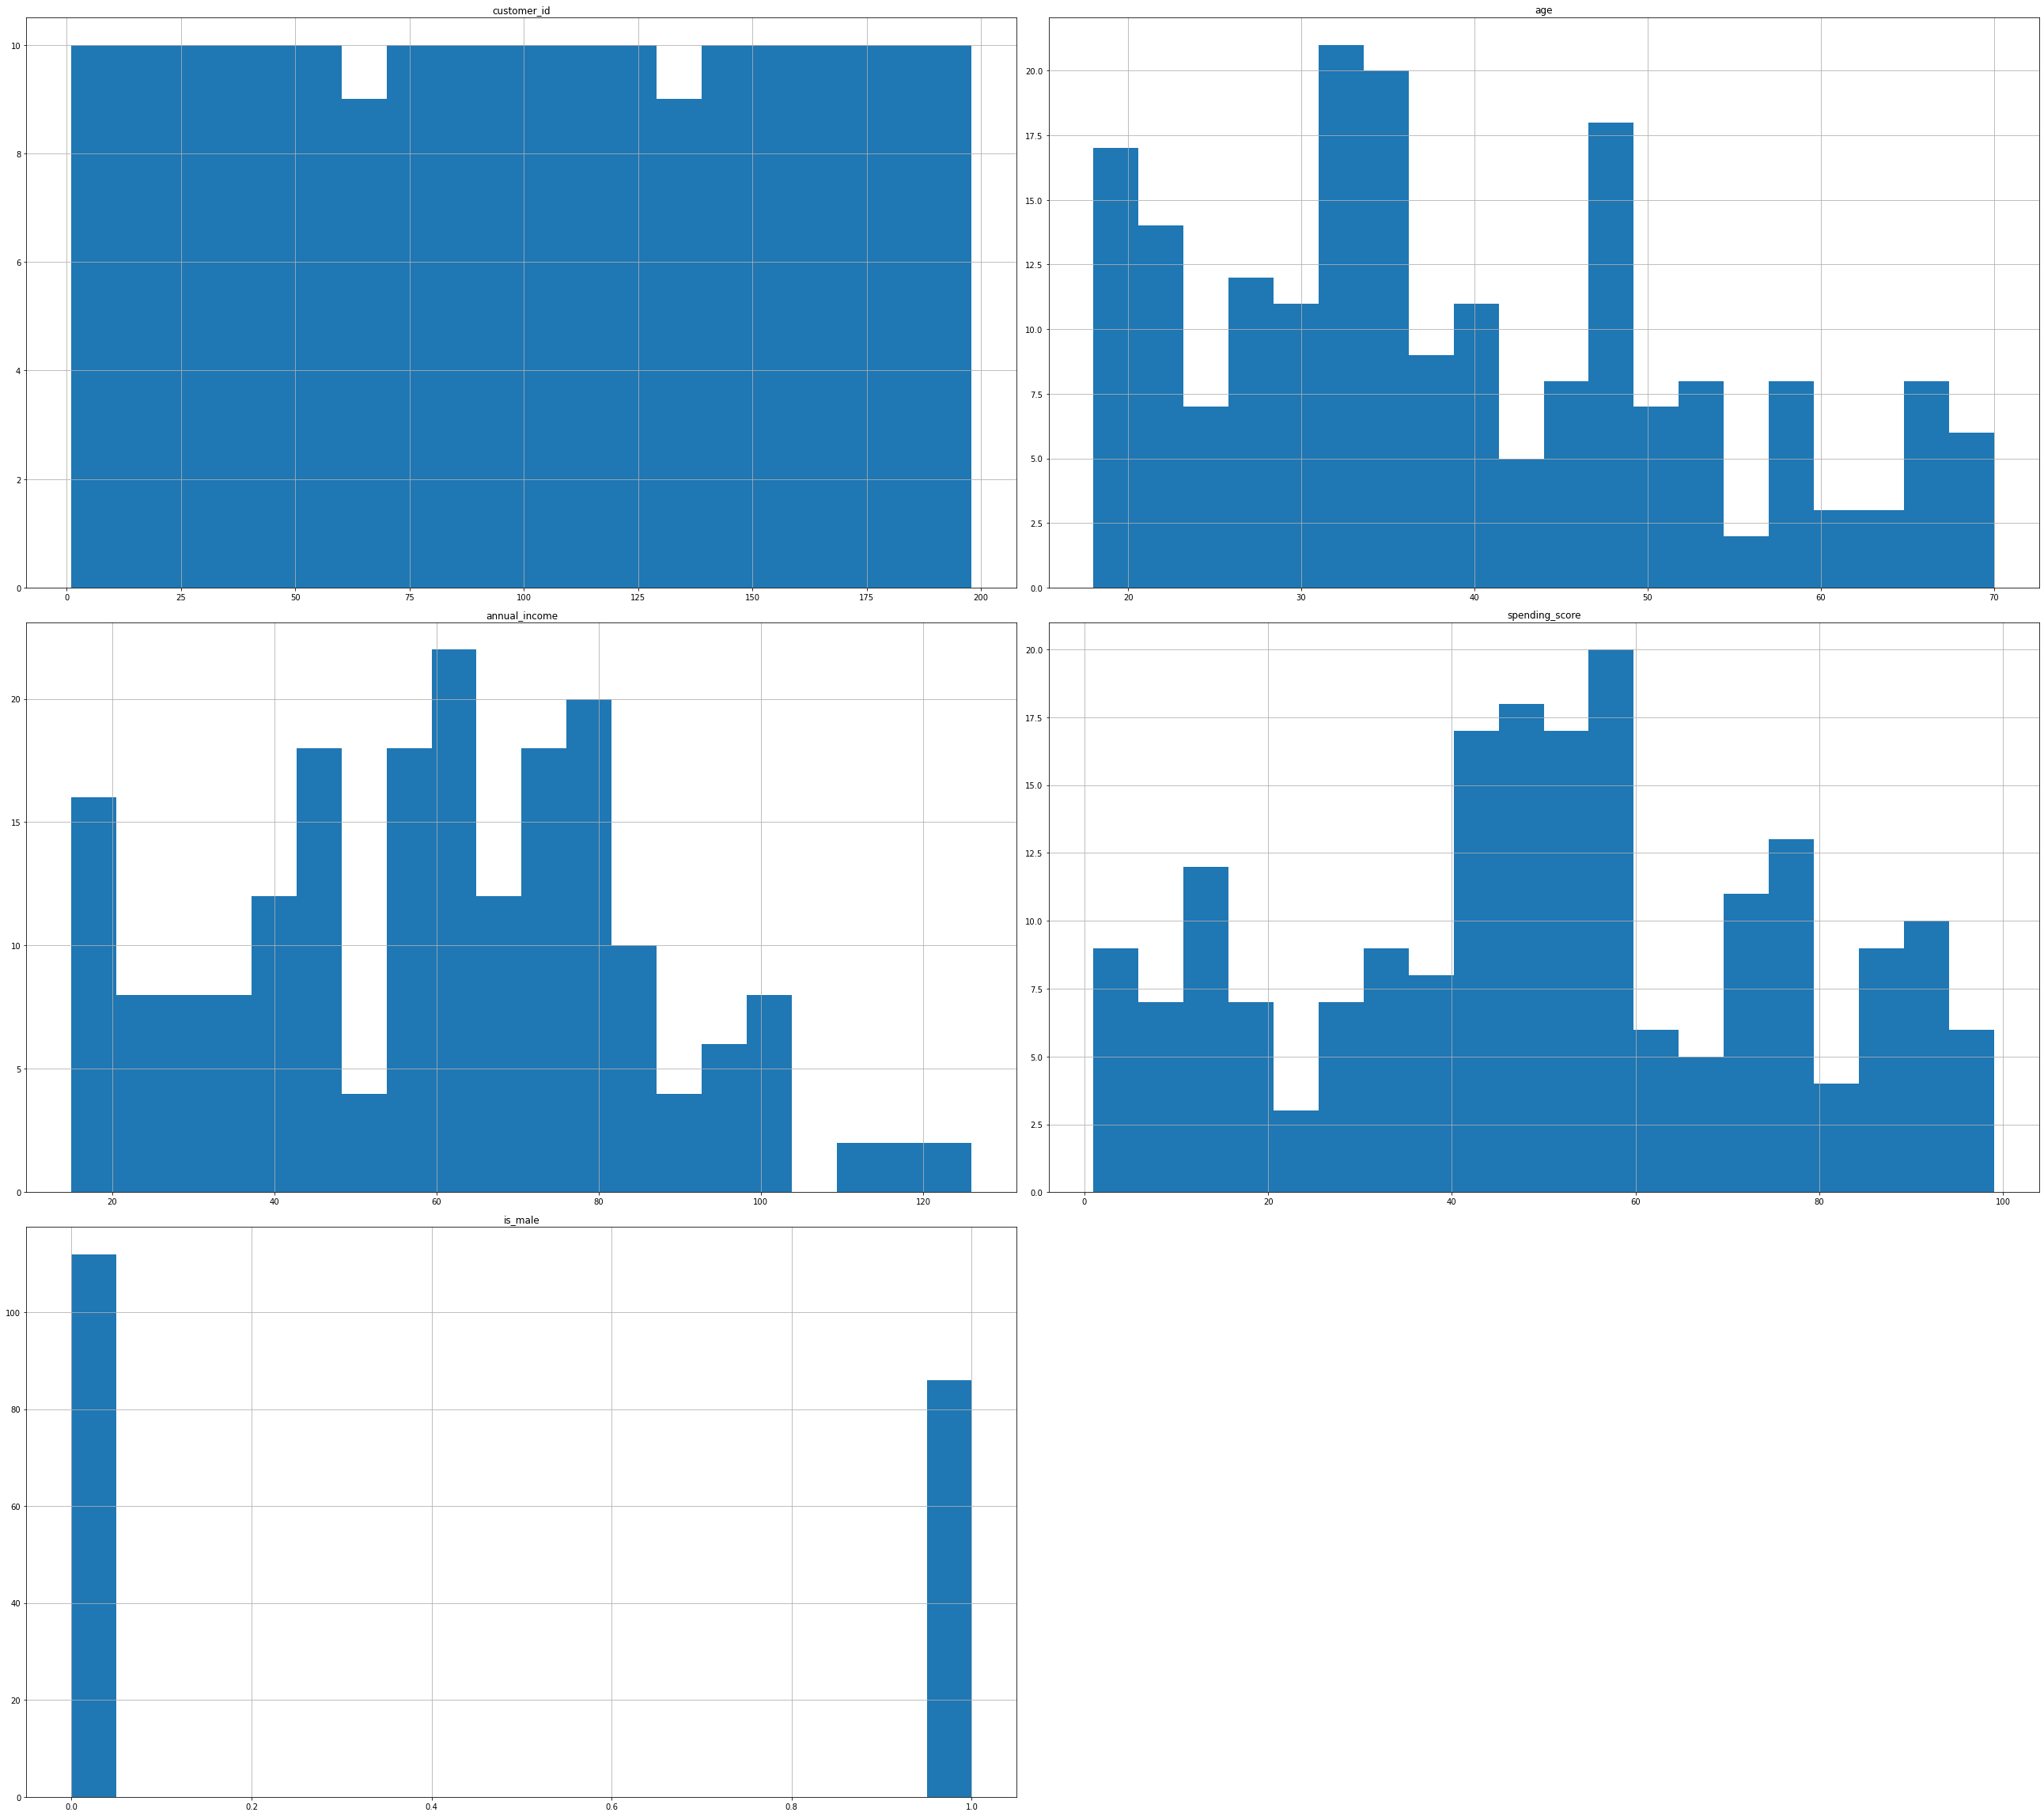

In [10]:
wrangle.hist_data(mall_df)

## Conclusion: spending_score is normally distributed.

- `age` and `annual_income` are skewed right. I will want to use spearman's correlation test when testing the linear relationships due to the skew.
- The sample has slightly fewer males.

## 2. Does spending_score differ across gender

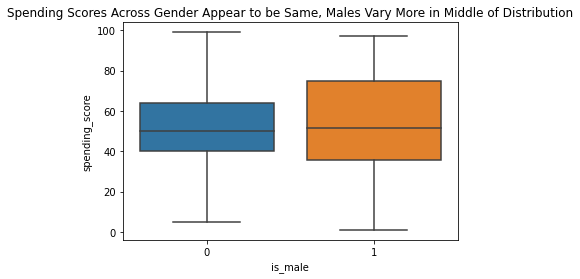

In [17]:
sns.boxplot(train.is_male, train.spending_score)
plt.title('Spending Scores Across Gender Appear to be Same, Males Vary More in Middle of Distribution')
plt.show()

#### Hypothesis Test: 2 Sample T Test
- Group(1): Average Spending Score of not_male (0)
- Group(2): Average Spending Score of is_male (1)

>H(o): There is no significant difference between the average spending scores of **group1** males and **group2** not males


#### First using `Levene's Test` to test for equal variances between the two groups. 
>H(o) assumes group1 var == group2 var

- If p-value > .05, we can say that the variances are not significantly different and set the argument in `ttest_ind` of `equal_var` to be **True**.
- If p-value < .05, we say the variances are NOT equal and set `equal_var` to be **False**.


In [21]:
stats.levene(train[train.is_male==0].spending_score, train[train.is_male ==1].spending_score)

LeveneResult(statistic=2.1379886505631975, pvalue=0.14639412765949228)

In [27]:
t, p = stats.levene(train[train.is_male==0].spending_score, train[train.is_male ==1].spending_score)

if p > .05:
    print(f'With a p-value of {round(p, 4)}, we fail to reject H(o) and cannot confidently assert that the variances between the two groups are not equal')
else:
    print(f'With a p-value of {round(p, 4)}, we reject H(o) and can confidently assert that the variances between the two groups are not equal')

With a p-value of 0.1464, we fail to reject H(o) and cannot confidently assert that the variances between the two groups are not equal


In [29]:
stats.ttest_ind(train[train.is_male==0].spending_score, train[train.is_male ==1].spending_score, equal_var = True)

Ttest_indResult(statistic=-0.31267242544413254, pvalue=0.7550909591158667)

>#### Conclusion: There is not a significant difference in spending score across genders.

### 3. Is there a relationship between `spending_score` and `annual_income`?

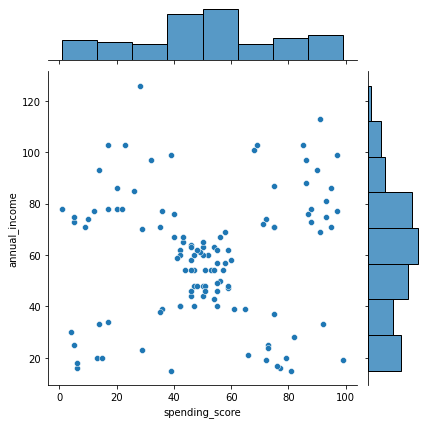

In [33]:
sns.jointplot(x = 'spending_score', y = 'annual_income', data = train)
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

### Conclusion: 
>There is not a linear relationship between `annual_income` and `spending_score`, but there appears to be a relationship shaped somewhat like an x. It makes me think that another variable is interacting leading to the highs and lows on the X.

### 4. Is there a relationship between `age` and `spending_score`?
1. Plot age by spending_score.
2. Linear Relationship? If there appears to be something, I can run a spearman's test to confirm. (Spearman because age is not normally distributed. If it was, I would use a pearson's test.)
3. Create groups of ages and compare mean spending score using t-test and plotting.

Text(336.9714285714286, 0.5, 'Spending Score')

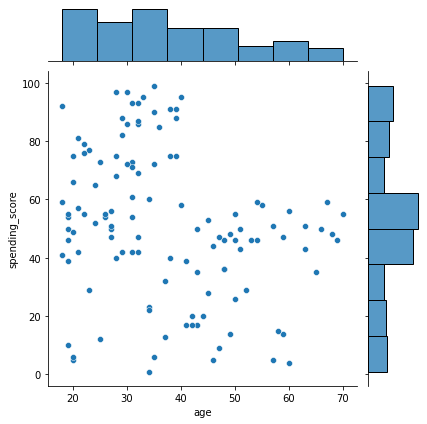

In [35]:
sns.jointplot('age', 'spending_score', data = train)
plt.xlabel("Age")
plt.ylabel("Spending Score")

> It appears that after `40` or so, max spending score drops. (range is limited to < 60 +/-) If I bin the age `(0, 40)`, `(40, 80)`, will there be a significant difference in spending score?

#### Two Tailed T Test

In [36]:
# creating columns for age bins
train['age_bin'] = pd.cut(train.age, [0, 40, 80])

train.head()

,customer_id,age,annual_income,spending_score,is_male,age_bin
181,182,32,97,86,0,"(0, 40]"
48,49,29,40,42,0,"(0, 40]"
34,35,49,33,14,0,"(40, 80]"
185,186,30,99,97,1,"(0, 40]"
113,114,19,64,46,1,"(0, 40]"


<AxesSubplot:xlabel='age_bin', ylabel='spending_score'>

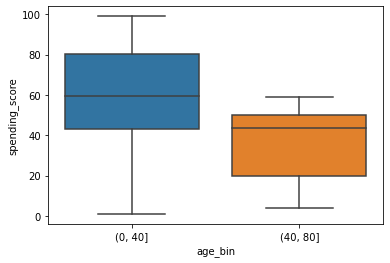

In [37]:
sns.boxplot(train.age_bin, train.spending_score)

In [38]:
# Levene's test to test equality of variances
stats.levene(train[train.age <= 40].spending_score, train[train.age > 40].spending_score)

LeveneResult(statistic=8.105188565471254, pvalue=0.005221578454098131)

>p < .05: `equal_var` = **False**

In [39]:
stats.ttest_ind(train[train.age <= 40].spending_score, train[train.age > 40].spending_score, equal_var = False)

Ttest_indResult(statistic=5.899848364840159, pvalue=3.7357667437931227e-08)

### Conclusion:
> p > .05, there is no significant difference in `spending_score` between > 40 and 40+ groups

### 5. Is there a relationship between `annual_income` and `spending_score`?

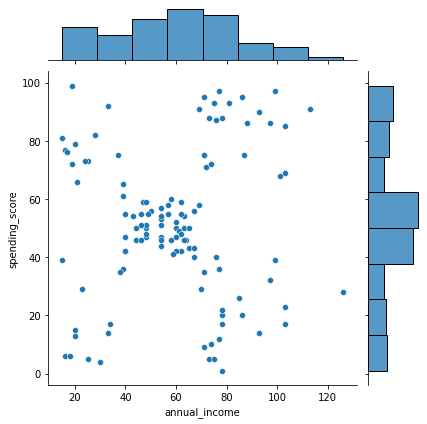

In [40]:
sns.jointplot(train.annual_income, train.spending_score)

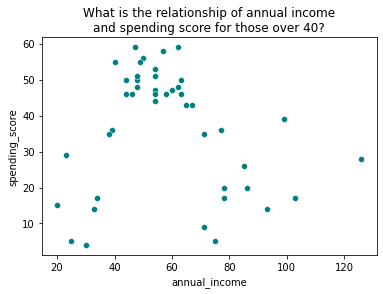

In [41]:
sns.scatterplot(x='annual_income', y='spending_score',
                data=train[train.age > 40],
                color='teal'
               )
plt.title("What is the relationship of annual income\nand spending score for those over 40?")
plt.show()

In [42]:
# bin income into 3 bins

train['income_bin'] = pd.cut(train.annual_income, [0, 40, 70, 140])

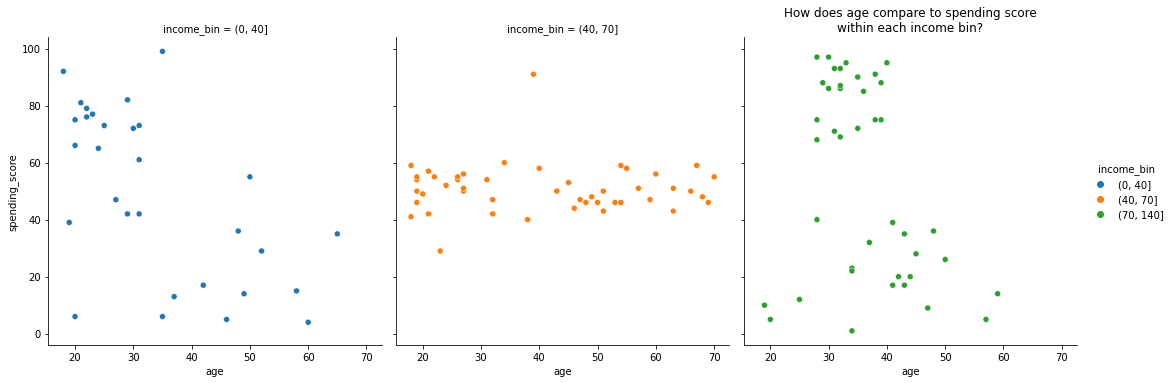

In [47]:
sns.relplot(x='age', y='spending_score',
               data=train, hue='income_bin', col = 'income_bin')
plt.title("How does age compare to spending score\nwithin each income bin?")
plt.show()